### Imports and Global Configuration

In [1]:
import datetime

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Constants across architectures
N_INPUT_CH = 22
N_PCA_COMP = 16
N_INPUT_SAMPLES = 1000
N_INPUT_SAMPLES_TRIMMED = 500
EPOCHS = 250

# Data loading
- Converts to 32-bit floats to reduce training time
- Adjusts labels to be in the range \[0-3\]
- Generates onehot encoded copies of all values that represent a class index

In [3]:
# Load the data and convert from 64 to 32 bit floats
X_train_valid = np.load("../data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("../data/y_train_valid.npy").astype(np.float32)
X_test = np.load("../data/X_test.npy").astype(np.float32)
y_test = np.load("../data/y_test.npy").astype(np.float32)

# Swap the axes of our EEG signals so the channels are the last axis
X_train_valid = X_train_valid.transpose((0,2,1))
X_test = X_test.transpose((0,2,1))

# Split Train+Val data to Train and Val sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid,
    test_size=0.2, random_state=42)

# Print our the shapes of the data we loaded for confirmation
print ('Training data shape: {}'.format(X_train.shape))
print ('Validation data shape: {}'.format(X_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation target shape: {}'.format(y_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

# Function to convert labels from single value class index to onehot vector
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

# Adjust the y labels to be in the range [0-3] and also generate equivalent onehot representations
y_train -= 769
y_valid -= 769
y_test -= 769
print('y_train:', y_train[:10])
print('y_valid:', y_valid[:10])
print('y_test:', y_test[:10])
y_train_1h = convert_to_one_hot(y_train)
y_valid_1h = convert_to_one_hot(y_valid)
y_test_1h = convert_to_one_hot(y_test)
print('y_train_1h:')
print(y_train_1h[:4])
print('y_valid_1h:')
print(y_valid_1h[:4])
print('y_test_1h:')
print(y_test_1h[:4])

Training data shape: (1692, 1000, 22)
Validation data shape: (423, 1000, 22)
Test data shape: (443, 1000, 22)
Training target shape: (1692,)
Validation target shape: (423,)
Test target shape: (443,)
y_train: [3. 1. 1. 1. 1. 1. 3. 1. 1. 2.]
y_valid: [0. 2. 1. 2. 2. 1. 2. 3. 0. 3.]
y_test: [1. 0. 2. 3. 3. 2. 2. 3. 3. 0.]
y_train_1h:
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
y_valid_1h:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
y_test_1h:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


# Data Augmentation

Augmenting the limited training data was critical to achieve high performance on our design. Below, the loaded data is augmented in-place before being passed to any network. Many approaches were tried, and not all resulted in performance changes.

### Beneficial Augmentations
Update these fields with actual numbers when we have models included. Comment out the relevant augmentation, then rerun training and report the difference in val and/or test accuracy.
- Cropping each time-series signal to just the first 500 samples (2 seconds) of data
    - Cropping the last 500 samples seemed to net worse performance, but both are higher than the baseline 1000 samples
- Normalizing each time-series signal to zero mean and unit variance
    - This is not the same as 'extracting the mean image' from homeworks - every signal of every channel is modified independently.
    - This is designed so that the time domain signals have more predictable statistics.

### Neutral or Deterimental Augmentations
- Adding channels that were filtered to only include \mu and \beta frequencies showed no performance improvement on any model. This tripled the number of channels in each example from 22 to 66.
    - The idea was to pass the neural network better features, since the \mu and \beta frequencies are purported to be highly correlated with movement.
    - The networks we tried probably had no problem learning matched filters for these frequencies if those are beneficial filters. The first layer kernels certainly have sufficient parameters to do this in all models.
- Adding examples with varying levels of Additive White Gaussian Noise (AWGN) had no effect on performance
    - The number of examples was increase 10x (up to 21150), where every set of examples had a fixed sigma used to generate AWGN added to all channels
    - This was designed as a mitigation against overfitting, but did not seem to help with the overfitting issue.

## Data Augmentation Implementation

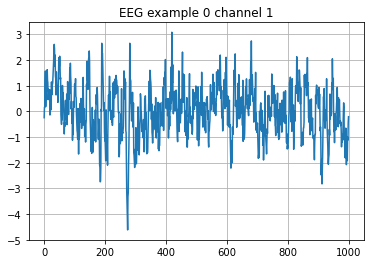

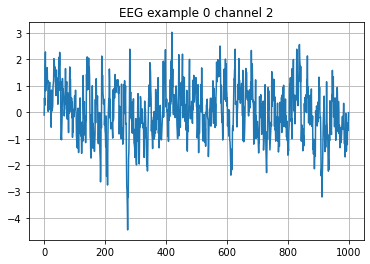

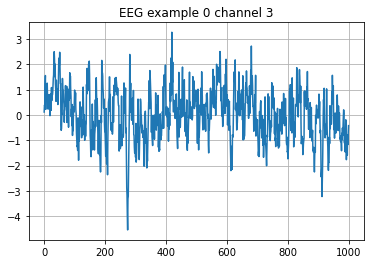

In [4]:
# Save copies of the original for the Baseline (Model 1)
X_train_baseline = np.copy(X_train)
X_valid_baseline = np.copy(X_valid)
X_test_baseline = np.copy(X_test)

# Normalize each time series signal of each channel to have zero mean and unit variance
# This is fine to do on the test set, since it is independent of example
samp_axis = 1
X_train -= np.expand_dims(np.mean(X_train, axis=samp_axis), samp_axis)
X_valid -= np.expand_dims(np.mean(X_valid, axis=samp_axis), samp_axis)
X_test -= np.expand_dims(np.mean(X_test, axis=samp_axis), samp_axis)
X_train /= np.expand_dims(np.std(X_train, axis=samp_axis), samp_axis)
X_valid /= np.expand_dims(np.std(X_valid, axis=samp_axis), samp_axis)
X_test /= np.expand_dims(np.std(X_test, axis=samp_axis), samp_axis)

# Generate some plots to visually verify
for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train[0,:,i])
    plt.grid()
    plt.show()

## PCA

In [5]:
# Generate a trimmed time series with the first 500 samples (2 seconds @ fs=250Hz)
# This seems to work better with PCA
X_train_trimmed = X_train[:,:N_INPUT_SAMPLES_TRIMMED,:]
X_valid_trimmed = X_valid[:,:N_INPUT_SAMPLES_TRIMMED,:]
X_test_trimmed = X_test[:,:N_INPUT_SAMPLES_TRIMMED,:]

# Merge the example and time axes, we want to drop channel dimensions
X_train_reshaped = X_train_trimmed.reshape(
    (X_train_trimmed.shape[0]*X_train_trimmed.shape[1], X_train_trimmed.shape[2]))

# Create a PCA instance and fit the training data
pca = PCA(n_components=N_PCA_COMP)
pca.fit(X_train_reshaped)
X_train_transformed = np.empty(
    (X_train_trimmed.shape[0], X_train_trimmed.shape[1], N_PCA_COMP))
for i in range(len(X_train_trimmed)):
    # Iteratively apply the transformation to each instance of the original dataset
    X_train_transformed[i] = pca.transform(X_train_trimmed[i])

# Apply the same transformation to the validation and test sets
X_valid_transformed = np.empty((X_valid_trimmed.shape[0], X_valid_trimmed.shape[1], N_PCA_COMP))
X_test_transformed = np.empty((X_test_trimmed.shape[0], X_test_trimmed.shape[1], N_PCA_COMP))
for i in range(len(X_valid)):
    X_valid_transformed[i] = pca.transform(X_valid_trimmed[i])
for i in range(len(X_test)):
    X_test_transformed[i] = pca.transform(X_test_trimmed[i])
    
# Print results as a sanity check
print ('Training data shape: {}'.format(X_train_transformed.shape))
print ('Validation data shape: {}'.format(X_valid_transformed.shape))
print ('Test data shape: {}'.format(X_test_transformed.shape))

Training data shape: (1692, 500, 16)
Validation data shape: (423, 500, 16)
Test data shape: (443, 500, 16)


# Models

## Model 1 - Baseline CNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_4 (Permute)          (None, 22, 1000)          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_5 (Permute)          (None, 976, 22, 40)       0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 976, 880)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 976, 40)           35240     
_________________________________________________________________
activation_4 (Activation)    (None, 976, 40)          

Epoch 29/250

Epoch 00029: val_categorical_accuracy did not improve from 0.56974
14/14 - 1s - loss: 0.9394 - categorical_accuracy: 0.6608 - val_loss: 1.1214 - val_categorical_accuracy: 0.5532 - lr: 1.0000e-04
Epoch 30/250

Epoch 00030: val_categorical_accuracy did not improve from 0.56974
14/14 - 1s - loss: 0.9272 - categorical_accuracy: 0.6608 - val_loss: 1.1159 - val_categorical_accuracy: 0.5674 - lr: 1.0000e-04
Epoch 31/250

Epoch 00031: val_categorical_accuracy improved from 0.56974 to 0.57210, saving model to best_cnn.h5
14/14 - 1s - loss: 0.9199 - categorical_accuracy: 0.6696 - val_loss: 1.1088 - val_categorical_accuracy: 0.5721 - lr: 1.0000e-04
Epoch 32/250

Epoch 00032: val_categorical_accuracy did not improve from 0.57210
14/14 - 1s - loss: 0.9023 - categorical_accuracy: 0.6779 - val_loss: 1.1111 - val_categorical_accuracy: 0.5626 - lr: 1.0000e-04
Epoch 33/250

Epoch 00033: val_categorical_accuracy did not improve from 0.57210
14/14 - 1s - loss: 0.8936 - categorical_accuracy: 

Epoch 68/250

Epoch 00068: val_categorical_accuracy did not improve from 0.62648
14/14 - 1s - loss: 0.6226 - categorical_accuracy: 0.7890 - val_loss: 0.9516 - val_categorical_accuracy: 0.6099 - lr: 1.0000e-04
Epoch 69/250

Epoch 00069: val_categorical_accuracy did not improve from 0.62648
14/14 - 1s - loss: 0.6236 - categorical_accuracy: 0.7949 - val_loss: 0.9694 - val_categorical_accuracy: 0.6052 - lr: 1.0000e-04
Epoch 70/250

Epoch 00070: val_categorical_accuracy did not improve from 0.62648
14/14 - 1s - loss: 0.6215 - categorical_accuracy: 0.7973 - val_loss: 0.9540 - val_categorical_accuracy: 0.6170 - lr: 1.0000e-04
Epoch 71/250

Epoch 00071: val_categorical_accuracy improved from 0.62648 to 0.63830, saving model to best_cnn.h5
14/14 - 1s - loss: 0.6157 - categorical_accuracy: 0.7920 - val_loss: 0.9501 - val_categorical_accuracy: 0.6383 - lr: 1.0000e-04
Epoch 72/250

Epoch 00072: val_categorical_accuracy did not improve from 0.63830
14/14 - 1s - loss: 0.6029 - categorical_accuracy: 

Epoch 107/250

Epoch 00107: val_categorical_accuracy did not improve from 0.65485
14/14 - 1s - loss: 0.4750 - categorical_accuracy: 0.8582 - val_loss: 0.9019 - val_categorical_accuracy: 0.6312 - lr: 1.0000e-04
Epoch 108/250

Epoch 00108: val_categorical_accuracy did not improve from 0.65485
14/14 - 1s - loss: 0.4634 - categorical_accuracy: 0.8658 - val_loss: 0.9202 - val_categorical_accuracy: 0.6454 - lr: 1.0000e-04
Epoch 109/250

Epoch 00109: val_categorical_accuracy did not improve from 0.65485
14/14 - 1s - loss: 0.4518 - categorical_accuracy: 0.8717 - val_loss: 0.9086 - val_categorical_accuracy: 0.6548 - lr: 1.0000e-04
Epoch 110/250

Epoch 00110: val_categorical_accuracy did not improve from 0.65485
14/14 - 1s - loss: 0.4808 - categorical_accuracy: 0.8587 - val_loss: 0.9236 - val_categorical_accuracy: 0.6407 - lr: 1.0000e-04
Epoch 111/250

Epoch 00111: val_categorical_accuracy did not improve from 0.65485
14/14 - 1s - loss: 0.4456 - categorical_accuracy: 0.8765 - val_loss: 0.8933 - 

Epoch 146/250

Epoch 00146: val_categorical_accuracy did not improve from 0.66430
14/14 - 1s - loss: 0.3644 - categorical_accuracy: 0.9066 - val_loss: 0.8858 - val_categorical_accuracy: 0.6501 - lr: 1.0000e-04
Epoch 147/250

Epoch 00147: val_categorical_accuracy did not improve from 0.66430
14/14 - 1s - loss: 0.3801 - categorical_accuracy: 0.9031 - val_loss: 0.8788 - val_categorical_accuracy: 0.6619 - lr: 1.0000e-04
Epoch 148/250

Epoch 00148: val_categorical_accuracy did not improve from 0.66430
14/14 - 1s - loss: 0.3656 - categorical_accuracy: 0.9113 - val_loss: 0.8878 - val_categorical_accuracy: 0.6596 - lr: 1.0000e-04
Epoch 149/250

Epoch 00149: val_categorical_accuracy did not improve from 0.66430
14/14 - 1s - loss: 0.3764 - categorical_accuracy: 0.9007 - val_loss: 0.8952 - val_categorical_accuracy: 0.6596 - lr: 1.0000e-04
Epoch 150/250

Epoch 00150: val_categorical_accuracy did not improve from 0.66430
14/14 - 1s - loss: 0.3637 - categorical_accuracy: 0.9167 - val_loss: 0.8977 - 

Epoch 185/250

Epoch 00185: val_categorical_accuracy did not improve from 0.67612
14/14 - 1s - loss: 0.3082 - categorical_accuracy: 0.9356 - val_loss: 0.8881 - val_categorical_accuracy: 0.6738 - lr: 5.0000e-05
Epoch 186/250

Epoch 00186: val_categorical_accuracy did not improve from 0.67612
14/14 - 1s - loss: 0.3144 - categorical_accuracy: 0.9255 - val_loss: 0.8912 - val_categorical_accuracy: 0.6643 - lr: 5.0000e-05
Epoch 187/250

Epoch 00187: val_categorical_accuracy did not improve from 0.67612
14/14 - 1s - loss: 0.3048 - categorical_accuracy: 0.9309 - val_loss: 0.8931 - val_categorical_accuracy: 0.6714 - lr: 5.0000e-05
Epoch 188/250

Epoch 00188: val_categorical_accuracy did not improve from 0.67612
14/14 - 1s - loss: 0.3196 - categorical_accuracy: 0.9232 - val_loss: 0.8905 - val_categorical_accuracy: 0.6619 - lr: 2.5000e-05
Epoch 189/250

Epoch 00189: val_categorical_accuracy did not improve from 0.67612
14/14 - 1s - loss: 0.3039 - categorical_accuracy: 0.9409 - val_loss: 0.8955 - 

Epoch 224/250

Epoch 00224: val_categorical_accuracy did not improve from 0.67849
14/14 - 1s - loss: 0.2903 - categorical_accuracy: 0.9403 - val_loss: 0.8917 - val_categorical_accuracy: 0.6596 - lr: 1.2500e-05
Epoch 225/250

Epoch 00225: val_categorical_accuracy did not improve from 0.67849
14/14 - 1s - loss: 0.2879 - categorical_accuracy: 0.9409 - val_loss: 0.8905 - val_categorical_accuracy: 0.6690 - lr: 1.2500e-05
Epoch 226/250

Epoch 00226: val_categorical_accuracy did not improve from 0.67849
14/14 - 1s - loss: 0.2941 - categorical_accuracy: 0.9391 - val_loss: 0.8904 - val_categorical_accuracy: 0.6714 - lr: 1.2500e-05
Epoch 227/250

Epoch 00227: val_categorical_accuracy did not improve from 0.67849
14/14 - 1s - loss: 0.2904 - categorical_accuracy: 0.9439 - val_loss: 0.8893 - val_categorical_accuracy: 0.6738 - lr: 1.2500e-05
Epoch 228/250

Epoch 00228: val_categorical_accuracy did not improve from 0.67849
14/14 - 1s - loss: 0.2893 - categorical_accuracy: 0.9403 - val_loss: 0.8906 - 

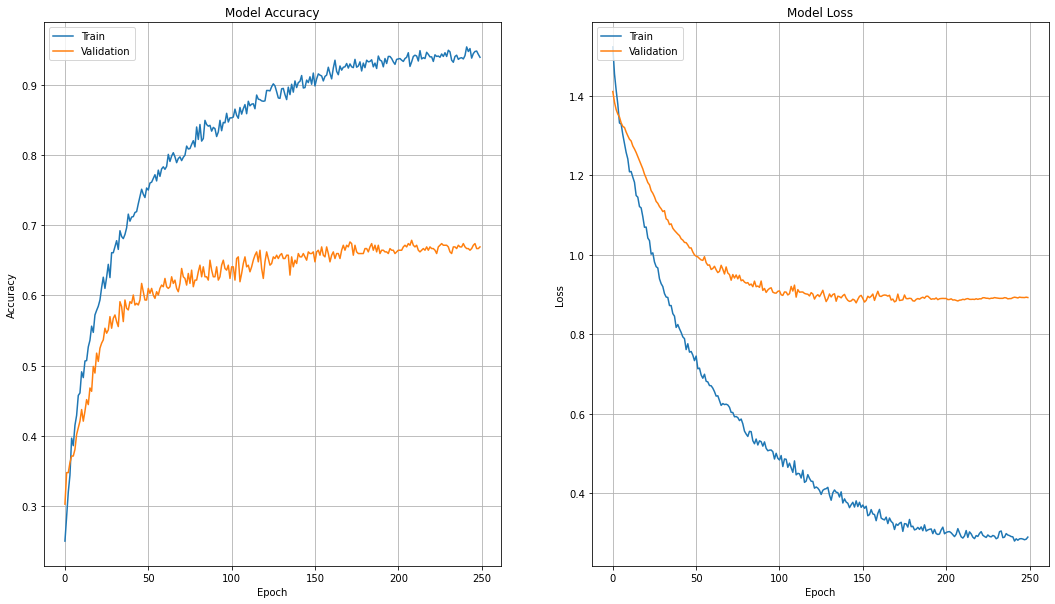

In [10]:
# Tweakable hyperparameters
n_filters = [40]
conv_sizes = [(1, 25)]
fc_sizes = [40, 4]
pool_sizes = [75]
pool_strides = [15]
fc_dropout = 0.5

# Model architecture
model = tf.keras.Sequential()
model.add(layers.Input((N_INPUT_SAMPLES, N_INPUT_CH)))
model.add(layers.Permute((2, 1)))
model.add(layers.Reshape(
    (N_INPUT_CH, N_INPUT_SAMPLES, 1)))
model.add(layers.Conv2D(
    filters=n_filters[0], kernel_size=conv_sizes[0],
    kernel_regularizer='l2',
    activation='elu'
))
model.add(layers.Permute((2, 1, 3)))
model.add(layers.Reshape(
    (N_INPUT_SAMPLES-conv_sizes[0][1]+1, N_INPUT_CH*n_filters[0])))
model.add(layers.Dense(fc_sizes[0], activation='elu'))
model.add(layers.Activation(lambda x: tf.pow(x, 2)))
model.add(layers.AveragePooling1D(pool_sizes[0], strides=pool_strides[0]))
model.add(layers.Activation(lambda x: tf.math.log(x)))
model.add(layers.Flatten())
model.add(layers.Dropout(fc_dropout))
model.add(layers.Dense(
    fc_sizes[1],
    activation='softmax',
    kernel_regularizer='l2',
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)
))

# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_cnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train_baseline, y_train_1h,
    validation_data=(X_valid_baseline, y_valid_1h),
    batch_size=128,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks
)

# Load our best weights and evaluate model on test dataset
print("\nTest accuracy:")
print("Final iteration:", model.evaluate(X_test_baseline, y_test_1h))
model.load_weights('best_cnn.h5')
print("Best Validation Accuracy Iteration:", model.evaluate(X_test_baseline, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()

## Model 2 - Baseline CNN with PCA and Optimal Preprocessing

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 16)]         0         
_________________________________________________________________
permute_2 (Permute)          (None, 16, 500)           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 500, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 476, 40)       1040      
_________________________________________________________________
permute_3 (Permute)          (None, 476, 16, 40)       0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 476, 640)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 476, 40)           25640 

Epoch 27/250

Epoch 00027: val_categorical_accuracy did not improve from 0.63357
14/14 - 0s - loss: 0.8875 - categorical_accuracy: 0.6619 - val_loss: 0.9346 - val_categorical_accuracy: 0.6241 - lr: 0.0010
Epoch 28/250

Epoch 00028: val_categorical_accuracy improved from 0.63357 to 0.64775, saving model to best_tweaked_cnn.h5
14/14 - 0s - loss: 0.8739 - categorical_accuracy: 0.6643 - val_loss: 0.9277 - val_categorical_accuracy: 0.6478 - lr: 0.0010
Epoch 29/250

Epoch 00029: val_categorical_accuracy improved from 0.64775 to 0.65248, saving model to best_tweaked_cnn.h5
14/14 - 0s - loss: 0.8618 - categorical_accuracy: 0.6714 - val_loss: 0.9180 - val_categorical_accuracy: 0.6525 - lr: 0.0010
Epoch 30/250

Epoch 00030: val_categorical_accuracy improved from 0.65248 to 0.65957, saving model to best_tweaked_cnn.h5
14/14 - 0s - loss: 0.8876 - categorical_accuracy: 0.6625 - val_loss: 0.9054 - val_categorical_accuracy: 0.6596 - lr: 0.0010
Epoch 31/250

Epoch 00031: val_categorical_accuracy did n

Epoch 66/250

Epoch 00066: val_categorical_accuracy did not improve from 0.70213
14/14 - 0s - loss: 0.6869 - categorical_accuracy: 0.7476 - val_loss: 0.8123 - val_categorical_accuracy: 0.7021 - lr: 0.0010
Epoch 67/250

Epoch 00067: val_categorical_accuracy improved from 0.70213 to 0.71868, saving model to best_tweaked_cnn.h5
14/14 - 0s - loss: 0.6879 - categorical_accuracy: 0.7441 - val_loss: 0.8135 - val_categorical_accuracy: 0.7187 - lr: 0.0010
Epoch 68/250

Epoch 00068: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.6680 - categorical_accuracy: 0.7553 - val_loss: 0.8226 - val_categorical_accuracy: 0.6950 - lr: 0.0010
Epoch 69/250

Epoch 00069: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.6771 - categorical_accuracy: 0.7512 - val_loss: 0.8201 - val_categorical_accuracy: 0.6832 - lr: 0.0010
Epoch 70/250

Epoch 00070: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.6591 - categorical_accuracy: 0.7618 -

Epoch 106/250

Epoch 00106: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5985 - categorical_accuracy: 0.7914 - val_loss: 0.7956 - val_categorical_accuracy: 0.7116 - lr: 0.0010
Epoch 107/250

Epoch 00107: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5946 - categorical_accuracy: 0.7967 - val_loss: 0.8033 - val_categorical_accuracy: 0.7139 - lr: 0.0010
Epoch 108/250

Epoch 00108: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5876 - categorical_accuracy: 0.7937 - val_loss: 0.7958 - val_categorical_accuracy: 0.7163 - lr: 0.0010
Epoch 109/250

Epoch 00109: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5985 - categorical_accuracy: 0.7837 - val_loss: 0.8110 - val_categorical_accuracy: 0.7069 - lr: 0.0010
Epoch 110/250

Epoch 00110: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5819 - categorical_accuracy: 0.8103 - val_loss: 0.8023 - val_categorical_

Epoch 146/250

Epoch 00146: val_categorical_accuracy did not improve from 0.73522
14/14 - 0s - loss: 0.5099 - categorical_accuracy: 0.8357 - val_loss: 0.7796 - val_categorical_accuracy: 0.7281 - lr: 5.0000e-04
Epoch 147/250

Epoch 00147: val_categorical_accuracy did not improve from 0.73522
14/14 - 0s - loss: 0.5348 - categorical_accuracy: 0.8227 - val_loss: 0.7946 - val_categorical_accuracy: 0.6998 - lr: 5.0000e-04
Epoch 148/250

Epoch 00148: val_categorical_accuracy did not improve from 0.73522
14/14 - 0s - loss: 0.5234 - categorical_accuracy: 0.8262 - val_loss: 0.7797 - val_categorical_accuracy: 0.7139 - lr: 5.0000e-04
Epoch 149/250

Epoch 00149: val_categorical_accuracy did not improve from 0.73522
14/14 - 0s - loss: 0.5161 - categorical_accuracy: 0.8381 - val_loss: 0.7857 - val_categorical_accuracy: 0.7163 - lr: 5.0000e-04
Epoch 150/250

Epoch 00150: val_categorical_accuracy did not improve from 0.73522
14/14 - 0s - loss: 0.5205 - categorical_accuracy: 0.8268 - val_loss: 0.7804 - 

Epoch 185/250

Epoch 00185: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.5143 - categorical_accuracy: 0.8227 - val_loss: 0.7807 - val_categorical_accuracy: 0.7329 - lr: 1.2500e-04
Epoch 186/250

Epoch 00186: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.5139 - categorical_accuracy: 0.8180 - val_loss: 0.7819 - val_categorical_accuracy: 0.7329 - lr: 1.2500e-04
Epoch 187/250

Epoch 00187: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.5040 - categorical_accuracy: 0.8322 - val_loss: 0.7839 - val_categorical_accuracy: 0.7376 - lr: 1.2500e-04
Epoch 188/250

Epoch 00188: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.4889 - categorical_accuracy: 0.8392 - val_loss: 0.7852 - val_categorical_accuracy: 0.7329 - lr: 1.2500e-04
Epoch 189/250

Epoch 00189: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.4990 - categorical_accuracy: 0.8322 - val_loss: 0.7841 - 


Epoch 00224: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.5109 - categorical_accuracy: 0.8322 - val_loss: 0.7832 - val_categorical_accuracy: 0.7187 - lr: 3.1250e-05
Epoch 225/250

Epoch 00225: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.4938 - categorical_accuracy: 0.8304 - val_loss: 0.7845 - val_categorical_accuracy: 0.7163 - lr: 3.1250e-05
Epoch 226/250

Epoch 00226: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.5037 - categorical_accuracy: 0.8363 - val_loss: 0.7847 - val_categorical_accuracy: 0.7187 - lr: 3.1250e-05
Epoch 227/250

Epoch 00227: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.4976 - categorical_accuracy: 0.8434 - val_loss: 0.7842 - val_categorical_accuracy: 0.7210 - lr: 3.1250e-05
Epoch 228/250

Epoch 00228: val_categorical_accuracy did not improve from 0.73759
14/14 - 0s - loss: 0.4881 - categorical_accuracy: 0.8387 - val_loss: 0.7825 - val_categorica

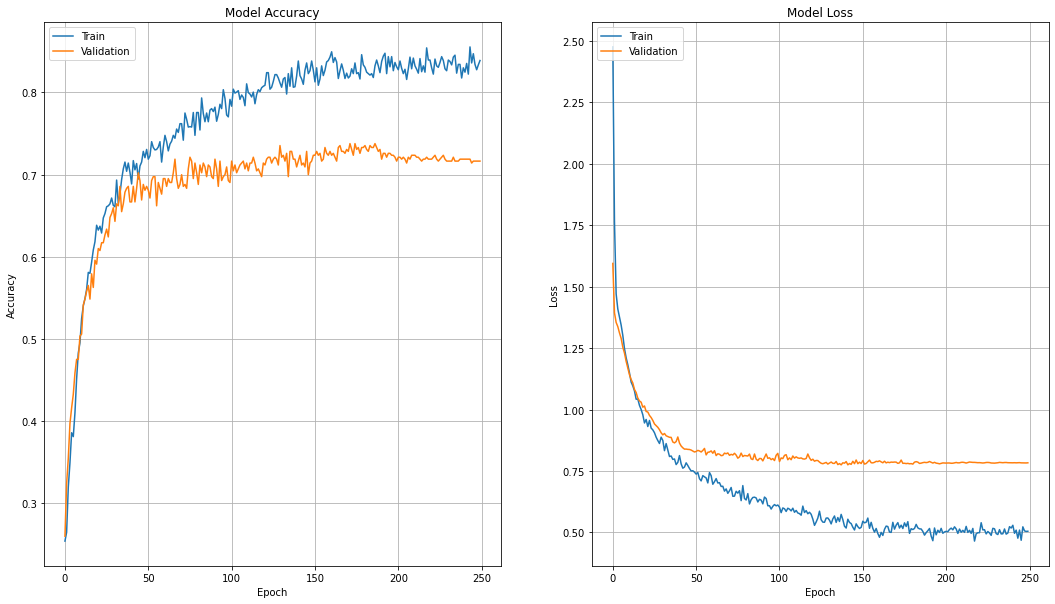

In [7]:
def ksquare(x):
    return tf.pow(x, 2)

def klog(x):
    return tf.math.log(x)

# Model architecture
input_ = layers.Input(shape=(N_INPUT_SAMPLES_TRIMMED, N_PCA_COMP))
p0 = layers.Permute(dims=(2,1))(input_)
r1 = layers.Reshape(target_shape=(N_PCA_COMP, N_INPUT_SAMPLES_TRIMMED, 1))(p0)
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu', kernel_regularizer='l2')(r1)
p1 = layers.Permute(dims=(2,1,3))(c1)
r2 = layers.Reshape((476, N_PCA_COMP*40))(p1)
d1 = layers.Dense(40, activation='elu')(r2)
sq1 = layers.Activation(ksquare)(d1)
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
log1 = layers.Activation(klog)(ap1)
f1 = layers.Flatten()(log1)
d2 = layers.Dropout(0.85)(f1)
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model = tf.keras.models.Model(inputs=input_, outputs=output_)
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_tweaked_cnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train_transformed, y_train_1h,
    validation_data=(X_valid_transformed, y_valid_1h),
    batch_size=128,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks
)

# Load our best weights and evaluate model on test dataset
print("\nTest accuracy:")
print("Final iteration:", model.evaluate(X_test_transformed, y_test_1h))
model.load_weights('best_tweaked_cnn.h5')
print("Best Validation Accuracy Iteration:", model.evaluate(X_test_transformed, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()

## Model 3 - SCNN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
spatial_conv_0 (Conv2D)      (None, 1000, 12, 100)     1100      
_________________________________________________________________
spatial_conv_1 (Conv2D)      (None, 1000, 1, 100)      120000    
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 1, 100)      400       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 1000, 1, 100)      0         
_________________________________________________________________
temporal_conv_0 (Conv2D)     (None, 977, 1, 40)        9600

Epoch 27/250

Epoch 00027: val_categorical_accuracy did not improve from 0.63830
27/27 - 1s - loss: 0.7866 - categorical_accuracy: 0.9480 - val_loss: 1.5499 - val_categorical_accuracy: 0.6217 - lr: 5.0000e-04
Epoch 28/250

Epoch 00028: val_categorical_accuracy did not improve from 0.63830
27/27 - 1s - loss: 0.7832 - categorical_accuracy: 0.9391 - val_loss: 1.5329 - val_categorical_accuracy: 0.6359 - lr: 5.0000e-04
Epoch 29/250

Epoch 00029: val_categorical_accuracy did not improve from 0.63830
27/27 - 1s - loss: 0.7635 - categorical_accuracy: 0.9368 - val_loss: 1.4757 - val_categorical_accuracy: 0.6194 - lr: 5.0000e-04
Epoch 30/250

Epoch 00030: val_categorical_accuracy did not improve from 0.63830
27/27 - 1s - loss: 0.7241 - categorical_accuracy: 0.9492 - val_loss: 1.6038 - val_categorical_accuracy: 0.6288 - lr: 5.0000e-04
Epoch 31/250

Epoch 00031: val_categorical_accuracy did not improve from 0.63830
27/27 - 1s - loss: 0.7033 - categorical_accuracy: 0.9515 - val_loss: 1.6279 - val_c

Epoch 66/250

Epoch 00066: val_categorical_accuracy did not improve from 0.65957
27/27 - 1s - loss: 0.3807 - categorical_accuracy: 0.9799 - val_loss: 1.3225 - val_categorical_accuracy: 0.6525 - lr: 5.0000e-04
Epoch 67/250

Epoch 00067: val_categorical_accuracy did not improve from 0.65957
27/27 - 1s - loss: 0.3776 - categorical_accuracy: 0.9829 - val_loss: 1.3378 - val_categorical_accuracy: 0.6454 - lr: 5.0000e-04
Epoch 68/250

Epoch 00068: val_categorical_accuracy did not improve from 0.65957
27/27 - 1s - loss: 0.3896 - categorical_accuracy: 0.9746 - val_loss: 1.3686 - val_categorical_accuracy: 0.6596 - lr: 5.0000e-04
Epoch 69/250

Epoch 00069: val_categorical_accuracy did not improve from 0.65957
27/27 - 1s - loss: 0.3985 - categorical_accuracy: 0.9669 - val_loss: 1.4172 - val_categorical_accuracy: 0.6194 - lr: 5.0000e-04
Epoch 70/250

Epoch 00070: val_categorical_accuracy did not improve from 0.65957
27/27 - 1s - loss: 0.4242 - categorical_accuracy: 0.9580 - val_loss: 1.4275 - val_c


Epoch 00105: val_categorical_accuracy did not improve from 0.67376
27/27 - 1s - loss: 0.3296 - categorical_accuracy: 0.9787 - val_loss: 1.5053 - val_categorical_accuracy: 0.6123 - lr: 5.0000e-04
Epoch 106/250

Epoch 00106: val_categorical_accuracy did not improve from 0.67376
27/27 - 1s - loss: 0.2989 - categorical_accuracy: 0.9923 - val_loss: 1.2775 - val_categorical_accuracy: 0.6596 - lr: 2.5000e-04
Epoch 107/250

Epoch 00107: val_categorical_accuracy did not improve from 0.67376
27/27 - 1s - loss: 0.2732 - categorical_accuracy: 0.9982 - val_loss: 1.2481 - val_categorical_accuracy: 0.6501 - lr: 2.5000e-04
Epoch 108/250

Epoch 00108: val_categorical_accuracy improved from 0.67376 to 0.68085, saving model to best_scnn.h5
27/27 - 1s - loss: 0.2627 - categorical_accuracy: 0.9982 - val_loss: 1.2124 - val_categorical_accuracy: 0.6809 - lr: 2.5000e-04
Epoch 109/250

Epoch 00109: val_categorical_accuracy did not improve from 0.68085
27/27 - 1s - loss: 0.2541 - categorical_accuracy: 0.9965 -

Epoch 144/250

Epoch 00144: val_categorical_accuracy improved from 0.68085 to 0.68558, saving model to best_scnn.h5
27/27 - 1s - loss: 0.1791 - categorical_accuracy: 0.9994 - val_loss: 1.1157 - val_categorical_accuracy: 0.6856 - lr: 1.2500e-04
Epoch 145/250

Epoch 00145: val_categorical_accuracy did not improve from 0.68558
27/27 - 1s - loss: 0.1791 - categorical_accuracy: 0.9988 - val_loss: 1.1600 - val_categorical_accuracy: 0.6832 - lr: 1.2500e-04
Epoch 146/250

Epoch 00146: val_categorical_accuracy did not improve from 0.68558
27/27 - 1s - loss: 0.1763 - categorical_accuracy: 0.9988 - val_loss: 1.1263 - val_categorical_accuracy: 0.6548 - lr: 1.2500e-04
Epoch 147/250

Epoch 00147: val_categorical_accuracy did not improve from 0.68558
27/27 - 1s - loss: 0.1754 - categorical_accuracy: 0.9976 - val_loss: 1.3174 - val_categorical_accuracy: 0.6407 - lr: 1.2500e-04
Epoch 148/250

Epoch 00148: val_categorical_accuracy did not improve from 0.68558
27/27 - 1s - loss: 0.1770 - categorical_accu

Epoch 183/250

Epoch 00183: val_categorical_accuracy did not improve from 0.69267
27/27 - 1s - loss: 0.1439 - categorical_accuracy: 0.9982 - val_loss: 2.3099 - val_categorical_accuracy: 0.5012 - lr: 6.2500e-05
Epoch 184/250

Epoch 00184: val_categorical_accuracy did not improve from 0.69267
27/27 - 1s - loss: 0.1407 - categorical_accuracy: 0.9982 - val_loss: 1.0530 - val_categorical_accuracy: 0.6714 - lr: 6.2500e-05
Epoch 185/250

Epoch 00185: val_categorical_accuracy did not improve from 0.69267
27/27 - 1s - loss: 0.1420 - categorical_accuracy: 0.9982 - val_loss: 2.0183 - val_categorical_accuracy: 0.5437 - lr: 6.2500e-05
Epoch 186/250

Epoch 00186: val_categorical_accuracy did not improve from 0.69267
27/27 - 1s - loss: 0.1413 - categorical_accuracy: 1.0000 - val_loss: 1.5531 - val_categorical_accuracy: 0.6217 - lr: 6.2500e-05
Epoch 187/250

Epoch 00187: val_categorical_accuracy did not improve from 0.69267
27/27 - 1s - loss: 0.1420 - categorical_accuracy: 0.9982 - val_loss: 1.1321 - 

Epoch 222/250

Epoch 00222: val_categorical_accuracy did not improve from 0.69504
27/27 - 1s - loss: 0.1247 - categorical_accuracy: 0.9994 - val_loss: 1.1051 - val_categorical_accuracy: 0.6738 - lr: 1.5625e-05
Epoch 223/250

Epoch 00223: val_categorical_accuracy did not improve from 0.69504
27/27 - 1s - loss: 0.1256 - categorical_accuracy: 0.9982 - val_loss: 1.0623 - val_categorical_accuracy: 0.6903 - lr: 1.5625e-05
Epoch 224/250

Epoch 00224: val_categorical_accuracy did not improve from 0.69504
27/27 - 1s - loss: 0.1228 - categorical_accuracy: 1.0000 - val_loss: 1.0503 - val_categorical_accuracy: 0.6596 - lr: 1.5625e-05
Epoch 225/250

Epoch 00225: val_categorical_accuracy did not improve from 0.69504
27/27 - 1s - loss: 0.1218 - categorical_accuracy: 0.9994 - val_loss: 1.0302 - val_categorical_accuracy: 0.6903 - lr: 1.5625e-05
Epoch 226/250

Epoch 00226: val_categorical_accuracy did not improve from 0.69504
27/27 - 1s - loss: 0.1226 - categorical_accuracy: 1.0000 - val_loss: 1.1013 - 

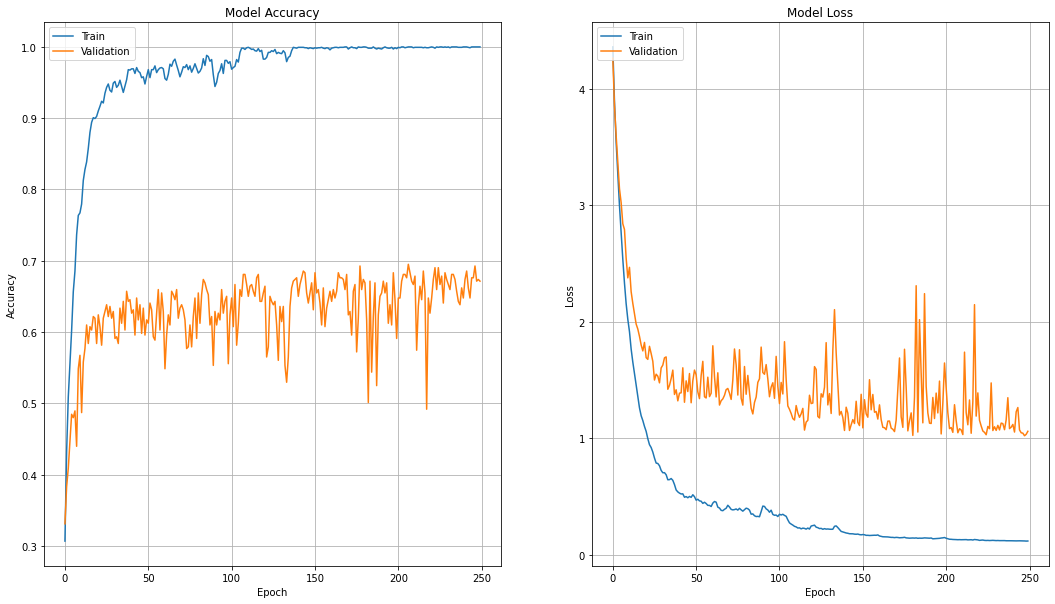

In [8]:
# Model Architecture
def SCNN(inputshape, outputshape, params=None):

    params = dict() if params is None else params

    temp_layers = int(params.get('temp_layers', 4))
    steps = int(params.get('steps', 2))
    temporal = int(params.get('temporal', 24))
    temp_pool = int(params.get('temp_pool', 20))
    lunits = [int(x) for x in params.get('lunits', [200, 40])]
    activation = params.get('activation', keras.activations.selu)
    reg = float(params.get('regularization', 0.01))
    do = min(1., max(0., float(params.get('dropout', 0.55))))

    convs = [inputshape[-1] // steps for _ in range(1, steps)]
    convs += [inputshape[-1] - sum(convs) + len(convs)]

    ins = keras.layers.Input(inputshape)
    conv = keras.layers.Reshape((inputshape[0], inputshape[1], 1))(ins)

    for i, c in enumerate(convs):
        conv = keras.layers.Conv2D(
            lunits[0] // len(convs), (1, c),
            activation=activation,
            use_bias=False, 
            name='spatial_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    for i in range(temp_layers):
        conv = keras.layers.Conv2D(
            lunits[1], (temporal, 1),
            activation=activation,
            use_bias=False, name='temporal_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.AveragePooling2D((temp_pool, 1))(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    outs = keras.layers.Flatten()(conv)

    for units in lunits[2:]:
        outs = keras.layers.Dense(
            units, activation=activation,
            kernel_regularizer=keras.layers.regularizers.l2(reg))(outs)
        outs = keras.layers.BatchNormalization()(outs)
        outs = keras.layers.Dropout(do)(outs)
    outs = keras.layers.Dense(
        outputshape, activation='softmax', name='OUT',
        kernel_regularizer=tf.keras.regularizers.l2(reg))(outs)

    return keras.models.Model(ins, outs)


# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model = SCNN(inputshape=(N_INPUT_SAMPLES, N_INPUT_CH), outputshape=4)
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_scnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train, y_train_1h,
    validation_data=(X_valid, y_valid_1h),
    batch_size=64,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
)

# Load our best weights and evaluate model on test dataset
print("\nTest accuracy:")
print("Final iteration:", model.evaluate(X_test, y_test_1h))
model.load_weights('best_scnn.h5')
print("Best Validation Accuracy Iteration:", model.evaluate(X_test, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()

## Model 4 - SCNN+LSTM

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
spatial_conv_0 (Conv2D)      (None, 1000, 12, 100)     1200      
_________________________________________________________________
spatial_conv_1 (Conv2D)      (None, 1000, 1, 100)      120100    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 1, 100)      400       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 1000, 1, 100)      0         
_________________________________________________________________
temporal_conv_0 (Conv2D)     (None, 977, 1, 40)        9600

Epoch 19/250

Epoch 00019: val_categorical_accuracy improved from 0.52955 to 0.53664, saving model to best_rescnn.h5
27/27 - 1s - loss: 5.9777 - categorical_accuracy: 0.5254 - val_loss: 5.9032 - val_categorical_accuracy: 0.5366 - lr: 1.0000e-04
Epoch 20/250

Epoch 00020: val_categorical_accuracy did not improve from 0.53664
27/27 - 1s - loss: 5.8498 - categorical_accuracy: 0.5230 - val_loss: 5.8420 - val_categorical_accuracy: 0.5225 - lr: 1.0000e-04
Epoch 21/250

Epoch 00021: val_categorical_accuracy improved from 0.53664 to 0.54137, saving model to best_rescnn.h5
27/27 - 1s - loss: 5.7847 - categorical_accuracy: 0.5313 - val_loss: 5.7055 - val_categorical_accuracy: 0.5414 - lr: 1.0000e-04
Epoch 22/250

Epoch 00022: val_categorical_accuracy did not improve from 0.54137
27/27 - 1s - loss: 5.6740 - categorical_accuracy: 0.5331 - val_loss: 5.6766 - val_categorical_accuracy: 0.5319 - lr: 1.0000e-04
Epoch 23/250

Epoch 00023: val_categorical_accuracy improved from 0.54137 to 0.55083, saving

Epoch 57/250

Epoch 00057: val_categorical_accuracy improved from 0.65485 to 0.66194, saving model to best_rescnn.h5
27/27 - 1s - loss: 3.2628 - categorical_accuracy: 0.7033 - val_loss: 3.4007 - val_categorical_accuracy: 0.6619 - lr: 1.0000e-04
Epoch 58/250

Epoch 00058: val_categorical_accuracy improved from 0.66194 to 0.66667, saving model to best_rescnn.h5
27/27 - 1s - loss: 3.2228 - categorical_accuracy: 0.7163 - val_loss: 3.3618 - val_categorical_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 59/250

Epoch 00059: val_categorical_accuracy did not improve from 0.66667
27/27 - 1s - loss: 3.1899 - categorical_accuracy: 0.6998 - val_loss: 3.2777 - val_categorical_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 60/250

Epoch 00060: val_categorical_accuracy did not improve from 0.66667
27/27 - 1s - loss: 3.1279 - categorical_accuracy: 0.7210 - val_loss: 3.2589 - val_categorical_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 61/250

Epoch 00061: val_categorical_accuracy improved from 0.66667 to 0.67849, saving

Epoch 95/250

Epoch 00095: val_categorical_accuracy did not improve from 0.70922
27/27 - 1s - loss: 2.1241 - categorical_accuracy: 0.8014 - val_loss: 2.3754 - val_categorical_accuracy: 0.6950 - lr: 1.0000e-04
Epoch 96/250

Epoch 00096: val_categorical_accuracy did not improve from 0.70922
27/27 - 1s - loss: 2.1041 - categorical_accuracy: 0.7831 - val_loss: 2.3268 - val_categorical_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 97/250

Epoch 00097: val_categorical_accuracy did not improve from 0.70922
27/27 - 1s - loss: 2.0667 - categorical_accuracy: 0.7926 - val_loss: 2.3619 - val_categorical_accuracy: 0.6903 - lr: 1.0000e-04
Epoch 98/250

Epoch 00098: val_categorical_accuracy improved from 0.70922 to 0.71158, saving model to best_rescnn.h5
27/27 - 1s - loss: 2.0678 - categorical_accuracy: 0.7902 - val_loss: 2.3113 - val_categorical_accuracy: 0.7116 - lr: 1.0000e-04
Epoch 99/250

Epoch 00099: val_categorical_accuracy improved from 0.71158 to 0.71868, saving model to best_rescnn.h5
27/27 - 1s 

Epoch 134/250

Epoch 00134: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 1.5107 - categorical_accuracy: 0.8475 - val_loss: 1.9000 - val_categorical_accuracy: 0.7116 - lr: 1.0000e-04
Epoch 135/250

Epoch 00135: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 1.5190 - categorical_accuracy: 0.8387 - val_loss: 2.0937 - val_categorical_accuracy: 0.6714 - lr: 1.0000e-04
Epoch 136/250

Epoch 00136: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 1.4989 - categorical_accuracy: 0.8493 - val_loss: 2.0098 - val_categorical_accuracy: 0.7021 - lr: 1.0000e-04
Epoch 137/250

Epoch 00137: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 1.4932 - categorical_accuracy: 0.8463 - val_loss: 1.9617 - val_categorical_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 138/250

Epoch 00138: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 1.4881 - categorical_accuracy: 0.8387 - val_loss: 1.9302 - 

Epoch 173/250

Epoch 00173: val_categorical_accuracy did not improve from 0.73050
27/27 - 1s - loss: 1.1349 - categorical_accuracy: 0.8877 - val_loss: 1.7088 - val_categorical_accuracy: 0.7139 - lr: 1.0000e-04
Epoch 174/250

Epoch 00174: val_categorical_accuracy did not improve from 0.73050
27/27 - 1s - loss: 1.1553 - categorical_accuracy: 0.8717 - val_loss: 1.7021 - val_categorical_accuracy: 0.7163 - lr: 1.0000e-04
Epoch 175/250

Epoch 00175: val_categorical_accuracy did not improve from 0.73050
27/27 - 1s - loss: 1.1547 - categorical_accuracy: 0.8806 - val_loss: 1.7530 - val_categorical_accuracy: 0.6927 - lr: 1.0000e-04
Epoch 176/250

Epoch 00176: val_categorical_accuracy did not improve from 0.73050
27/27 - 1s - loss: 1.1279 - categorical_accuracy: 0.8918 - val_loss: 1.7013 - val_categorical_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 177/250

Epoch 00177: val_categorical_accuracy did not improve from 0.73050
27/27 - 1s - loss: 1.1209 - categorical_accuracy: 0.8812 - val_loss: 1.7507 - 

Epoch 212/250

Epoch 00212: val_categorical_accuracy did not improve from 0.73995
27/27 - 1s - loss: 0.9048 - categorical_accuracy: 0.9167 - val_loss: 1.6138 - val_categorical_accuracy: 0.7092 - lr: 5.0000e-05
Epoch 213/250

Epoch 00213: val_categorical_accuracy did not improve from 0.73995
27/27 - 1s - loss: 0.8838 - categorical_accuracy: 0.9350 - val_loss: 1.5674 - val_categorical_accuracy: 0.7210 - lr: 5.0000e-05
Epoch 214/250

Epoch 00214: val_categorical_accuracy did not improve from 0.73995
27/27 - 1s - loss: 0.8892 - categorical_accuracy: 0.9149 - val_loss: 1.5867 - val_categorical_accuracy: 0.7187 - lr: 5.0000e-05
Epoch 215/250

Epoch 00215: val_categorical_accuracy did not improve from 0.73995
27/27 - 1s - loss: 0.8800 - categorical_accuracy: 0.9238 - val_loss: 1.6069 - val_categorical_accuracy: 0.7163 - lr: 5.0000e-05
Epoch 216/250

Epoch 00216: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00216: val_categorical_accuracy did not improve from 0.739

Epoch 250/250

Epoch 00250: val_categorical_accuracy did not improve from 0.73995
27/27 - 1s - loss: 0.7723 - categorical_accuracy: 0.9586 - val_loss: 1.5698 - val_categorical_accuracy: 0.7234 - lr: 6.2500e-06

Test accuracy:
14/14 [==============================] - 0s 8ms/step - loss: 1.6347 - categorical_accuracy: 0.7201
Final iteration: [1.6347185373306274, 0.7200902700424194]
14/14 [==============================] - 0s 8ms/step - loss: 1.6932 - categorical_accuracy: 0.7201
Best Validation Accuracy Iteration: [1.6931660175323486, 0.7200902700424194]


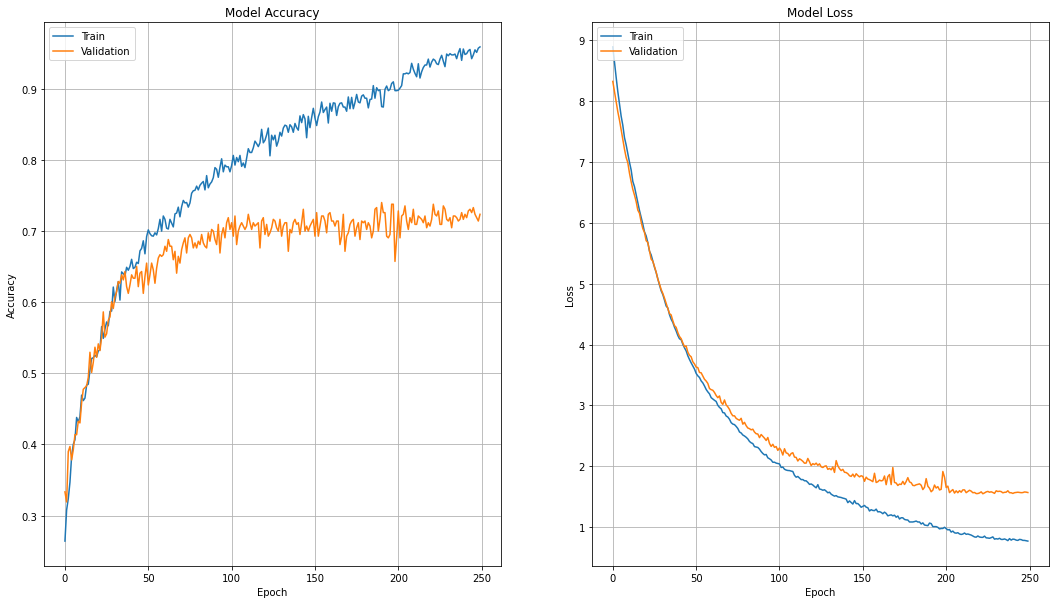

In [9]:
class AttentionLSTMIn(keras.layers.LSTM):
    """
    From: https://github.com/SPOClab-ca/SCNN/blob/master/SCNN/layers.py
    Keras LSTM layer (all keyword arguments preserved) with the addition of attention weights

    Attention weights are calculated as a function of the previous hidden state to the current LSTM step.
    Weights are applied either locally (across channels at current timestep) or globally (weight each sequence element
    of each channel).
    """
    ATT_STYLES = ['local', 'global']

    def __init__(self, units, alignment_depth: int = 1, style='local', alignment_units=None, implementation=2,
                 **kwargs):
        implementation = implementation if implementation > 0 else 2
        alignment_depth = max(0, alignment_depth)
        if isinstance(alignment_units, (list, tuple)):
            self.alignment_units = [int(x) for x in alignment_units]
            self.alignment_depth = len(self.alignment_units)
        else:
            self.alignment_depth = alignment_depth
            self.alignment_units = [alignment_units if alignment_units else units for _ in range(alignment_depth)]
        if style not in self.ATT_STYLES:
            raise TypeError('Could not understand style: ' + style)
        else:
            self.style = style
        super(AttentionLSTMIn, self).__init__(units, implementation=implementation, **kwargs)

    def build(self, input_shape):
        assert len(input_shape) > 2
        self.samples = input_shape[1]
        self.channels = input_shape[2]

        if self.style is self.ATT_STYLES[0]:
            # local attends over input vector
            units = [self.units + input_shape[-1]] + self.alignment_units + [self.channels]
        else:
            # global attends over the whole sequence for each feature
            units = [self.units + input_shape[1]] + self.alignment_units + [self.samples]
        self.attention_kernels = [self.add_weight(shape=(units[i-1], units[i]),
                                                name='attention_kernel_{0}'.format(i),
                                                initializer=self.kernel_initializer,
                                                regularizer=self.kernel_regularizer,
                                                trainable=True,
                                                constraint=self.kernel_constraint)
                                  for i in range(1, len(units))]

        if self.use_bias:
            self.attention_bias = [self.add_weight(shape=(u,),
                                                   name='attention_bias_{0}'.format(u),
                                                   trainable=True,
                                                   initializer=self.bias_initializer,
                                                   regularizer=self.bias_regularizer,
                                                   constraint=self.bias_constraint)
                                   for u in units[1:]]
        else:
            self.attention_bias = None
        super(AttentionLSTMIn, self).build(input_shape)

    def preprocess_input(self, inputs, training=None):
        self.input_tensor_hack = inputs
        return inputs

    def step(self, inputs, states):
        h_tm1 = states[0]

        if self.style is self.ATT_STYLES[0]:
            energy = K.concatenate((inputs, h_tm1))
        elif self.style is self.ATT_STYLES[1]:
            h_tm1 = K.repeat_elements(K.expand_dims(h_tm1), self.channels, -1)
            energy = K.concatenate((self.input_tensor_hack, h_tm1), 1)
            energy = K.permute_dimensions(energy, (0, 2, 1))
        else:
            raise NotImplementedError('{0}: not implemented'.format(self.style))

        for i, kernel in enumerate(self.attention_kernels):
            energy = K.dot(energy, kernel)
            if self.use_bias:
                energy = K.bias_add(energy, self.attention_bias[i])
            energy = self.activation(energy)

        alpha = K.softmax(energy)

        if self.style is self.ATT_STYLES[0]:
            inputs = inputs * alpha
        elif self.style is self.ATT_STYLES[1]:
            alpha = K.permute_dimensions(alpha, (0, 2, 1))
            weighted = self.input_tensor_hack * alpha
            inputs = K.sum(weighted, 1)

        return super(AttentionLSTMIn, self).step(inputs, states)
    
    
def RaSCNN(inputshape, outputshape, params=None):
    """
    Spatial summary convolutional neural network augmented with attention
    focused recurrence (Ra-SCNN) by Kostas, Pang, and Rudzics in "Machine
    learning for MEG during speec tasks."
    Adapted from https://github.com/SPOClab-ca/SCNN/blob/master/SCNN/models.py
    """
    ret_seq = True
    att_depth = 4
    attention = 76
    temp_layers = 4
    steps = 2
    temporal = 24
    temp_pool = 20

    lunits = [200, 40]
    activation = keras.activations.selu
    reg = float(0.01)
    dropout = 0.55

    convs = [inputshape[-1]//steps for _ in range(1, steps)]
    convs += [inputshape[-1] - sum(convs) + len(convs)]

    ins = keras.layers.Input(inputshape)
    conv = keras.layers.Reshape((inputshape[0], inputshape[1], 1))(ins)

    for i, c in enumerate(convs):
        conv = keras.layers.Conv2D(lunits[0]//len(convs), 
            (1, c), activation=activation,
            name='spatial_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg))(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.SpatialDropout2D(dropout)(conv)

    for i in range(temp_layers):
        conv = keras.layers.Conv2D(lunits[1], (temporal, 1), activation=activation,
            use_bias=False, name='temporal_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg))(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.AveragePooling2D((temp_pool, 1,))(conv)
    conv = keras.layers.SpatialDropout2D(dropout)(conv)
    conv = keras.layers.Reshape((45, 40))(conv)

    attn = keras.layers.Bidirectional(AttentionLSTMIn(attention,
        implementation=2,
        dropout=dropout,
        return_sequences=ret_seq,
        alignment_depth=att_depth,
        style='global',
        kernel_regularizer=tf.keras.regularizers.l2(reg),
        ))(conv)
    conv = keras.layers.BatchNormalization()(attn)

    if ret_seq:
        conv = keras.layers.Flatten()(conv)
    outs = conv
    for units in lunits[2:]:
        outs = keras.layers.Dense(units, activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(reg))(outs)
        outs = keras.layers.BatchNormalization()(outs)
        outs = keras.layers.Dropout(dropout)(outs)
    outs = keras.layers.Dense(outputshape, activation='softmax')(outs)

    return keras.models.Model(ins, outs)

# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model = RaSCNN(inputshape=(N_INPUT_SAMPLES, N_INPUT_CH), outputshape=4)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_rescnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train, y_train_1h,
    validation_data=(X_valid, y_valid_1h),
    batch_size=64,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
)

# Load our best weights and evaluate model on test dataset
print("\nTest accuracy:")
print("Final iteration:", model.evaluate(X_test, y_test_1h))
model.load_weights('best_rescnn.h5')
print("Best Validation Accuracy Iteration:", model.evaluate(X_test, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()